# 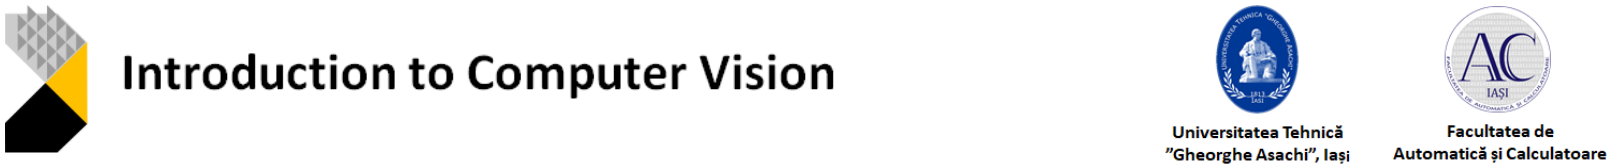

  The Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs. 
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 4: Obstacles detection based on disparity maps

## Week 2: Obstacle and ground detection based on disparity maps

**UV-isparity maps**

In order to extract the regions of interest (obstacle regions)
we will use the UV-disparity space. UV-disparity space is computed
from disparity map.

**A brief recap before moving on**

We saw that if we have two images of same scene, we can get depth information from that in an intuitive way. Below is an image and some simple mathematical formulas which proves that intuition.
<figure>
<center>
<img src='https://docs.opencv.org/3.1.0/stereo_depth.jpg' />
</center>
</figure>

The above diagram contains equivalent triangles. Writing their equivalent equations will yield us following result:

$$disparity=x−x′=\frac{Bf}{Z}$$
$x$ and $x′$ are the distance between points in image plane corresponding to the scene point 3D and their camera center. $B$ is the distance between two cameras (which we know) and $f$ is the focal length of camera (already known). So in short, above equation says that the $depth$ of a point in a scene is inversely proportional to the difference in distance of corresponding image points and their camera centers. So with this information, we can derive the depth of all pixels in an image. [text source: docs.opencv.org/4.2.0/ ]

**UV-disparity space**

After the disparity map is computed, we have to compute
the UV-disparity space.

*U-disparity* space is a column based matrix which stores
the same disparity values for every column from disparity map. 

$$u_{id} = \sum_{j = 0}^{rows}\delta_{ij}, \delta_{ij} = \{ ^{ 1, disp_{ij} = d}_{0, otherwise} , $$ 
where $u_{id}$ represents the value from U-disparity space which
cumulates the number of pixels with disparity $d$ from column $i$
in the disparity map. 

Same as *U-disparity* space, *V-disparity* space is a row based matrix which stores the disparity values for every column from disparity map.

$$v_{dj} = \sum_{i = 0}^{cols}\delta_{ij}, \delta_{ij} = \{ ^{ 1, disp_{ij} = d}_{0, otherwise} , $$ 

where $v_{dj}$ represents the value from V-disparity space which
cumulates the number of pixels with disparity $d$ from row $j$ in
the disparity map.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1Bjq3ySr1t-w_2SHILZxlsxHBWOQeXjcg' />
<figcaption>UV-disparity space example</figcaption></center>
</figure>


For more details see: [UV disparity based obstacle detection and pedestrian
classification in urban traffic scenarios](http://users.utcluj.ro/~igiosan/Resources/Papers/UV%20disparity%20based%20obstacle%20detection%20and%20pedestrian%20classification%20in%20urban%20traffic%20scenarios.pdf), A. Iloie, I. Giosan, S. Nedevschi, Computer Science Department, Technical University of Cluj-Napoca, Romania


### UV-disparity computation

In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt

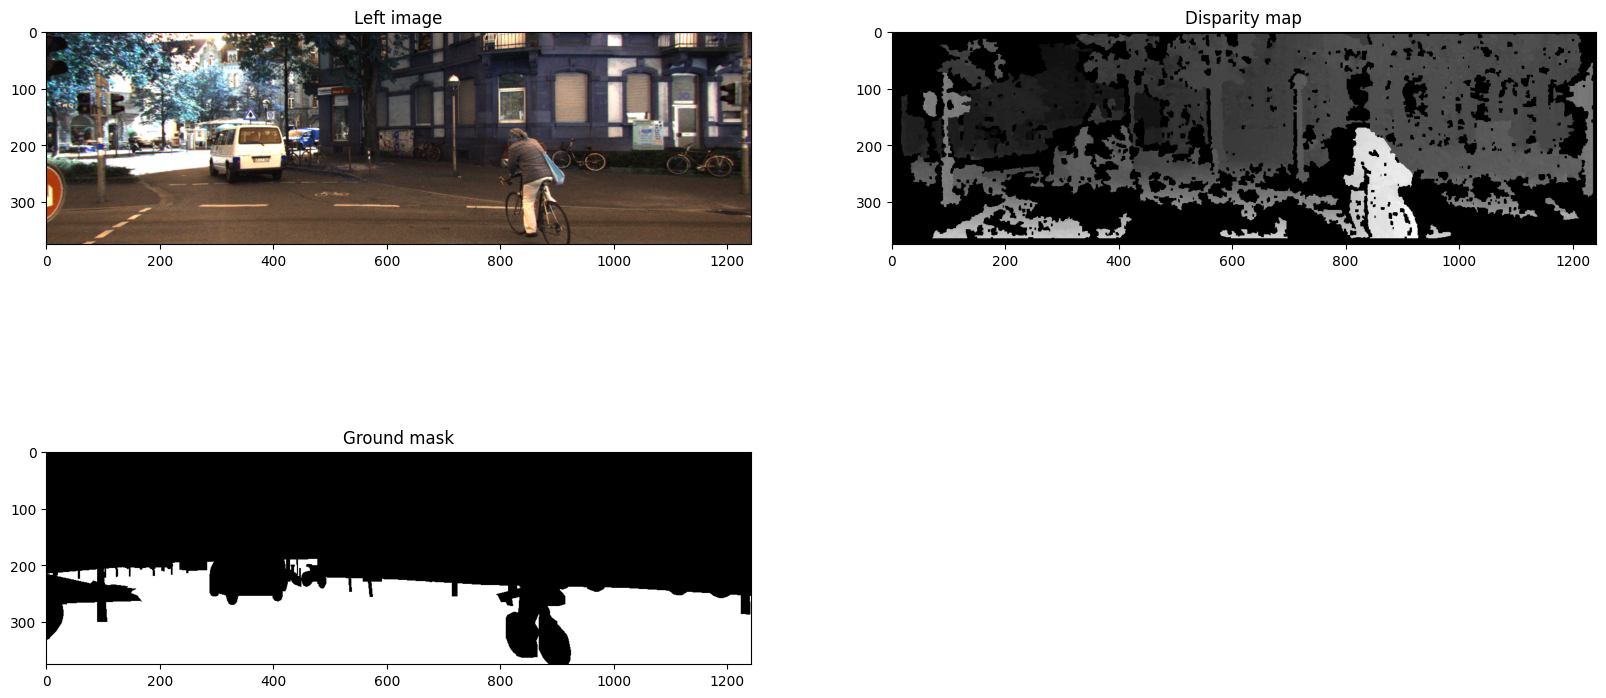

In [5]:
#TO DO: 
#(1) load the left image
#(2) load the disparity 
#(3) load the ground mask
#(4) display the 3 images

dataset_path = '.'
# File names for the images
left_img_path = f"{dataset_path}/left/000002_10.png"
disparity_path = f"{dataset_path}/disparity/000002_10.png"
groundMask_path = f"{dataset_path}/ground/000002_10.png"

# Load the images
left_img = cv2.imread(left_img_path)
disparity = cv2.imread(disparity_path, cv2.IMREAD_GRAYSCALE)
groundMask = cv2.imread(groundMask_path, cv2.IMREAD_GRAYSCALE)

# Display the images
fig = plt.figure(figsize=(20, 10))

# Left image
im1 = fig.add_subplot(2, 2, 1)
im1.set_title('Left image')
im1.imshow(left_img, cmap='gray')

# Disparity map
im2 = fig.add_subplot(2, 2, 2)
im2.set_title('Disparity map')
im2.imshow(disparity, cmap='gray')

# Ground mask
im3 = fig.add_subplot(2, 2, 3)
im3.set_title('Ground mask')
im3.imshow(groundMask, cmap='gray')

plt.show()

#### Object detection using U-disparity maps

In [6]:
#Steps to compute the U-disparity map
#TO DO:
#(1) using the ground mask, remove ground pixels from the disparity map
#(2) determine the U-Disparity height by computing the max value from the disparity map (computed at (1))
#(3) compute U-disparity map using the formula from above

def uDisparity(disparity, groundMask):
    # Clone the disparity image
    newDisparity = disparity.copy()

    # Remove ground pixels
    newDisparity[groundMask != 0] = 0

    # Compute max value
    max_disparity = newDisparity.max()

    # Compute U-disparity height
    udispHeight = max_disparity + 1

    # Create zero matrix to store the U-disparity
    udisp = np.zeros((udispHeight, disparity.shape[1]), dtype=np.uint8)

    # Compute U-disparity
    for col in range(disparity.shape[1]):
        for row in range(disparity.shape[0]):
            if newDisparity[row, col] != 0:
                udisp[newDisparity[row, col], col] += 1

    return udisp, udispHeight

In [7]:
#function that assign a color for each distinct region
#code source: https://stackoverflow.com/questions/46441893/connected-component-labeling-in-python
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    return labeled_img

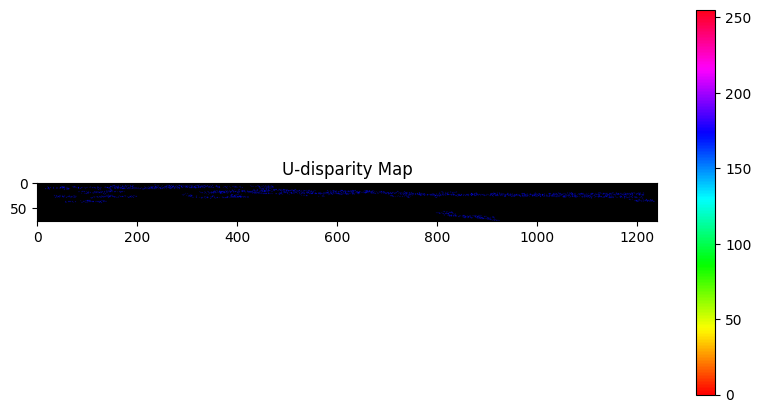

In [8]:
#compute U-disparity
udisp, udispHeight = uDisparity(disparity, groundMask)

# Show the U-disparity map
plt.figure(figsize=(10, 5))
plt.imshow(imshow_components(udisp), cmap='hsv')
plt.title('U-disparity Map')
plt.colorbar()
plt.show()

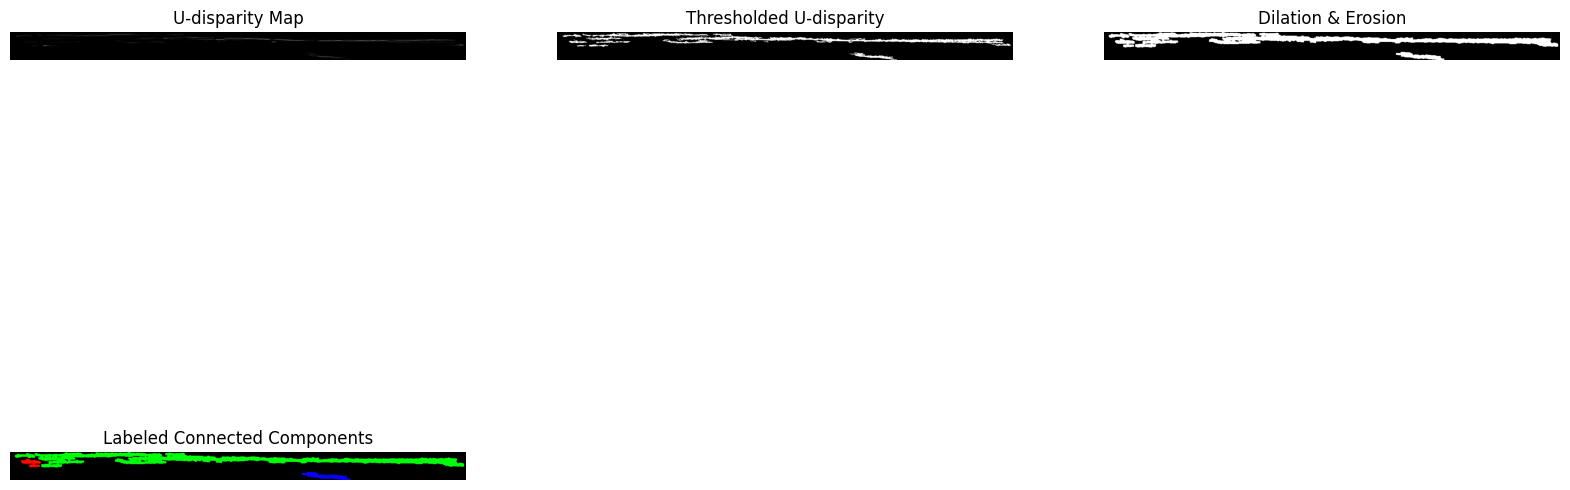

In [10]:
#We're just a few steps away from detected regions

#TO DO: we need to post-process the U-disparity map
#(1) apply a threshold on the U-disparity map
#(2) apply some morphological operation on the result obtained at (1) - dilate and then erode
#(3) use a connected components function to label eac region from the U-disparity map (the one from (2))
#(4) try to color each regions differently and display the result  

udisparity = np.uint8(udisp)
udisparity = cv2.cvtColor(udisparity, cv2.COLOR_GRAY2RGB)

# Apply threshold on the U-disparity map
threshold_value = 1
ret, thresholded_udisparity = cv2.threshold(udisparity, threshold_value, 255, cv2.THRESH_BINARY)

# Apply morphological operations (dilate and then erode)
kernel = np.ones((5, 5), np.uint8)
morphed_udisparity = cv2.dilate(thresholded_udisparity, kernel, iterations=1)
# Convert to grayscale before applying connected components
gray_morphed_udisparity = cv2.cvtColor(morphed_udisparity, cv2.COLOR_BGR2GRAY)

# Use connected components to label each region
num_labels, labels_im = cv2.connectedComponents(gray_morphed_udisparity)

# Color each region differently
labeled_img = imshow_components(labels_im)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.imshow(udisparity)
plt.title('U-disparity Map')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(thresholded_udisparity, cmap='gray')
plt.title('Thresholded U-disparity')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(morphed_udisparity, cmap='gray')
plt.title('Dilation & Erosion')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(labeled_img)
plt.title('Labeled Connected Components')
plt.axis('off')

plt.show()

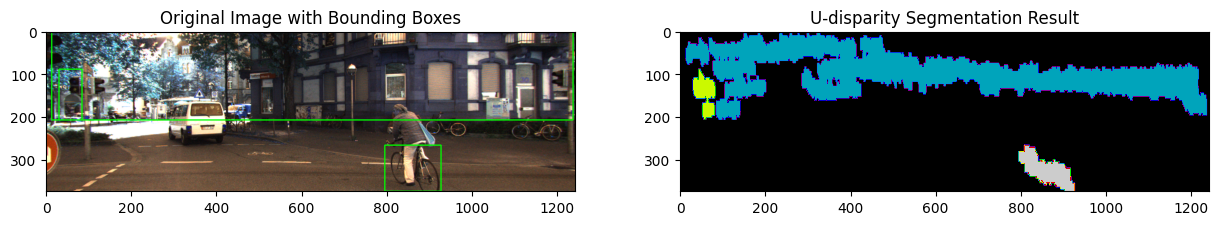

In [19]:
#Now, we're ready to go from U-disparity back to image space

#TO DO: we need to label the pixel from the original image with the label of the corresponding region from the U-disparity map
#(1) propagate labels from the U-disparity map to image space
#(2) try to separate each distinct region using the determined labels 
#    (remember the coins image from Image Processing (3rd year) and how we managed to separate and display each coin from the image, something similar we have to do here)
#(3) draw a bounding-box around each determined region and display the results, if the result is too noisy (small regions) try to filter the bounding-boxes 
#    (e.g. using area of rectangle and/or set a threshold for rectangle's width and height)
#(4) display the two results
#(5) answer the following questions:
#    Q1: how good are the results of the U-disparity segmentation? Is the result obtained as good as expected?
#    Q2: a bounding-box has more than one object?
#    (tip: search the terms => undersegmentation, oversegmentation)

# Ensure the dimensions of left_img and labels_im match
if left_img.shape[:2] != labels_im.shape:
    labels_im = cv2.resize(labels_im, (left_img.shape[1], left_img.shape[0]), interpolation=cv2.INTER_NEAREST)

# Convert labeled_image to CV_8UC1 format
labeled_image = np.uint8(labels_im)

# Separate each distinct region using the determined labels
region_images = []
for label in range(1, num_labels):
    region_mask = np.uint8(labeled_image == label)
    if region_mask.shape[:2] != left_img.shape[:2]:
        region_mask = cv2.resize(region_mask, (left_img.shape[1], left_img.shape[0]), interpolation=cv2.INTER_NEAREST)
    # Convert single-channel mask to 3-channel mask
    region_mask_3ch = cv2.cvtColor(region_mask, cv2.COLOR_GRAY2RGB)
    # Multiply image with region mask
    region_images.append(left_img * region_mask_3ch)


# Draw bounding boxes around each determined region
boundaries = []
for label in range(1, num_labels):
    region_mask = np.uint8(labeled_image == label)
    contours, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 10 and h > 10:  # Filter out small regions
            boundaries.append((x, y, w, h))

# Filter bounding boxes based on area, width, and height
filtered_boundaries = [box for box in boundaries if box[2] * box[3] > 100]

# Draw bounding boxes on the original image
image_with_boxes = left_img.copy()
for x, y, w, h in filtered_boundaries:
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_with_boxes)
plt.title('Original Image with Bounding Boxes')

plt.subplot(1, 2, 2)
plt.imshow(labeled_image, cmap='nipy_spectral')
plt.title('U-disparity Segmentation Result')

plt.show()

# Answering the questions
# Q1: Assess the quality of the U-disparity segmentation result
# Q2: Determine if a bounding box contains more than one object

In [20]:
def uDisparityToMask(disparity, uDispLabeled, udispHeight):
    dim = disparity.shape
    h = dim[0]
    w = dim[1]

    # Remove ground pixels
    disparity_no_ground = disparity.copy()
    disparity_no_ground[disparity_no_ground < 0] = 0

    # Create mask image with zeros
    mask = np.zeros((udispHeight, w), dtype=np.uint8)

    # Assign the labels from the U-disparity labeled image to the corresponding regions in the mask image
    for col in range(w):
        for row in range(h):
            label = uDispLabeled[row, col]
            if label > 0:
                mask[label, col] = label

    return mask

In [22]:
# Ensure the dimensions of left_img and labels_im match
if left_img.shape[:2] != labels_im.shape:
    labels_im = cv2.resize(labels_im, (left_img.shape[1], left_img.shape[0]), interpolation=cv2.INTER_NEAREST)

# Propagate labels from the U-disparity map to image space
labels = np.zeros_like(left_img[:,:,0], dtype=np.uint8)
for label in range(1, num_labels):  # Start from 1 to exclude background
    labels[labels_im == label] = label

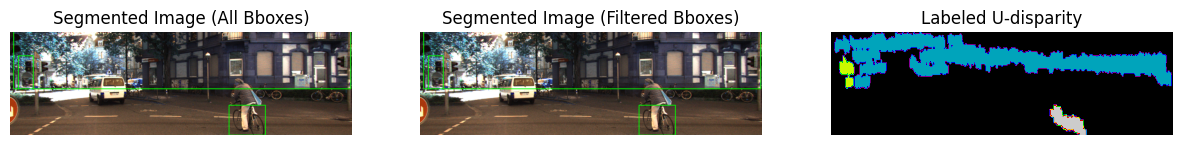

In [23]:
# Create copies of the original image
regionsAll = left_img.copy()
regionsFiltered = left_img.copy()

# Iterate through each label and draw a bounding-box for every segmented region
for i in range(1, num_labels):  # 0 represents background
    # Isolate the region labeled with "i"
    region_mask = (labels == i)

    # Compute bounding-box (rectangle)
    x, y, w, h = cv2.boundingRect(region_mask.astype(np.uint8))

    # Draw all bounding boxes
    cv2.rectangle(regionsAll, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Filter small bounding boxes
    if w * h > 100:  # Adjust the threshold as needed
        cv2.rectangle(regionsFiltered, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display results
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(regionsAll)
plt.title('Segmented Image (All Bboxes)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(regionsFiltered)
plt.title('Segmented Image (Filtered Bboxes)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Labeled U-disparity')
plt.axis('off')

plt.show()

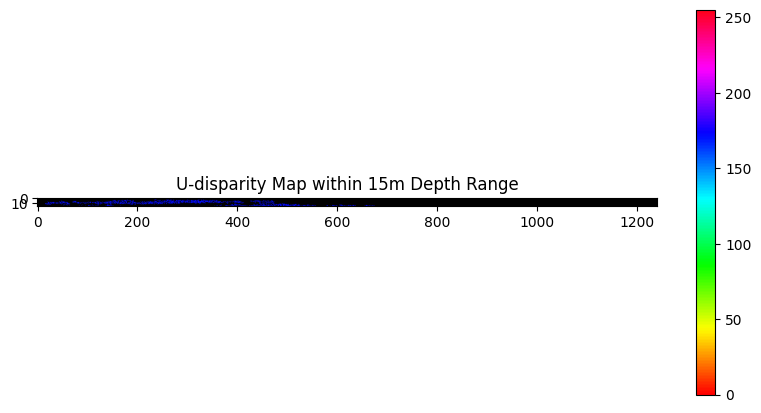

In [24]:
#TO DO: remember the camera parameters for the KITTI dataset used last time and how we removed some information from the images based on depth?
#(1) try to change the implementation and compute the U-disparity map using the information within 15m or 25m (filter the image based on depth information)
#(2) does the output of the segmentation change? Explain how.
# Function to compute U-disparity map within a specified depth range
def uDisparityWithinDepthRange(disparity, groundMask, depth_range):
    # Filter the disparity map based on depth range
    disparity_filtered = disparity.copy()
    disparity_filtered[disparity_filtered < depth_range[0]] = 0
    disparity_filtered[disparity_filtered > depth_range[1]] = 0

    # Compute U-disparity map using the filtered disparity map
    udisp, udispHeight = uDisparity(disparity_filtered, groundMask)
    return udisp

# Specify the depth range (e.g., within 15m)
depth_range_15m = (0, 15)

# Compute U-disparity map within 15m depth range
udisp_15m = uDisparityWithinDepthRange(disparity, groundMask, depth_range_15m)

# Show the U-disparity map within 15m depth range
plt.figure(figsize=(10, 5))
plt.imshow(imshow_components(udisp_15m), cmap='hsv')
plt.title('U-disparity Map within 15m Depth Range')
plt.colorbar()
plt.show()

#### Ground-plane detection using V-disparity maps

In [25]:
#until now we've used masks to filter ground-plane pixels
#let's move on and see how can we compute the ground plane using the V-disparity map
#Steps to compute ground-plane:
#(1) compute V-disparity map
#(2) apply Hough Transform to detect the lines from V-disparity
#(3) choose the best line
#(4) return to image space from V-disparity space and label all ground pixels

In [26]:
#TO DO: (1) compute the V-disparity map using the formula from above
def vDisparity(disparity):
    dim = disparity.shape
    h = dim[0]
    w = dim[1]

    # Compute max disparity value
    max_disparity = np.max(disparity)

    # Create zero matrix to store V-disparity
    vdisp = np.zeros((max_disparity + 1, w), dtype=np.uint8)

    # Compute V-disparity
    for col in range(w):
        for row in range(h):
            disp_val = disparity[row, col]
            if disp_val > 0:
                vdisp[disp_val, col] += 1

    return vdisp, w

In [27]:
#compute V-disparity
vdisp, vdispWidth = vDisparity(disparity)

In [28]:
def draw_lines(img, houghLines, color=[0, 255, 0], thickness=2):
    for line in houghLines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
 
            cv2.line(img,(x1,y1),(x2,y2),color,thickness)   
 
def weighted_img(img, initial_img, a=0.8, b=1., g=0.):
    return cv2.addWeighted(initial_img, a, img, b, g)

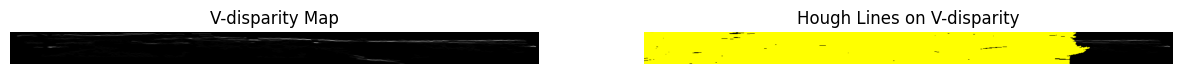

In [35]:
#TO DO: (1) apply Hough Transform to detect the lines from the V-disparity (see Project 1 for Hough)
#(2) choose the best line after applying Hough (tip: try to filter the computed V-disparity before applying Hough)
#(3) display results

# Apply Hough Transform to detect the lines from the V-disparity
houghLines = cv2.HoughLines(vdisp, rho=1, theta=np.pi/180, threshold=100)

# Choose the best line after applying Hough
# Here, you can implement a criteria to select the best line from the detected lines

# Convert the V-disparity map to a 3-channel image for visualization
vdisp_color = cv2.cvtColor(vdisp, cv2.COLOR_GRAY2BGR)

# Draw lines on the V-disparity map with a different color (e.g., red)
draw_lines(vdisp_color, houghLines, color=[0, 255, 0])  # Specify red color

# Display results: V-disparity map and Hough lines
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(vdisp, cmap='gray')
plt.title('V-disparity Map')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(vdisp_color)
plt.title('Hough Lines on V-disparity')
plt.axis('off')

plt.show()

In [36]:
#Now, we're ready to go from V-disparity back to image space

#TO DO: we need to label the ground pixel from the original image using the computed line
#(1) propagate line pixels from the V-disparity map to image space
 
def vDisparityToMask(disparity, hough_lines_image, vdispWidth):
    dim = disparity.shape
    h = dim[0]
    w = dim[1]

    # Extract the parameters of the detected line from the Hough lines image
    # Assuming only one line is detected, extract rho and theta
    rho, theta = hough_lines_image[0][0]

    # Compute the equation of the line in image space (y = mx + b)
    m = -np.cos(theta) / np.sin(theta)  # Slope
    b = rho / np.sin(theta)              # Intercept

    # Create zero mat to store the mask
    mask = np.zeros_like(disparity, dtype=np.uint8)

    # Compute mask by iterating over each pixel in the V-disparity map
    for col in range(vdispWidth):
        for row in range(h):
            # Compute the corresponding pixel coordinates in the original image space using the line equation
            x_img = col
            y_img = int(m * col + b)

            # Ensure the pixel coordinates are within the image bounds
            if 0 <= y_img < h:
                # Label the ground pixels in the original image using the computed line
                mask[y_img, x_img] = 255

    return mask

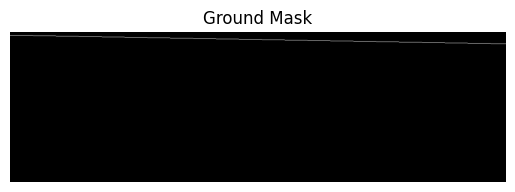

In [37]:
# Apply Hough Transform to detect the lines from the V-disparity
houghLines = cv2.HoughLines(vdisp, rho=1, theta=np.pi/180, threshold=100)

# Initialize ground mask as a blank image
groundMask = np.zeros_like(disparity)

if houghLines is not None:
    # Assuming only one line is detected, extract rho and theta
    rho, theta = houghLines[0][0]

    # Compute the equation of the line in image space (y = mx + b)
    m = -np.cos(theta) / np.sin(theta)  # Slope
    b = rho / np.sin(theta)              # Intercept

    # Iterate over each pixel in the V-disparity map
    for col in range(vdispWidth):
        for row in range(vdisp.shape[0]):
            # Compute the corresponding pixel coordinates in the original image space using the line equation
            x_img = col
            y_img = int(m * col + b)

            # Ensure the pixel coordinates are within the image bounds
            if 0 <= y_img < disparity.shape[0]:
                # Label the ground pixels in the original image using the computed line
                groundMask[y_img, x_img] = 255

# Display the ground mask
plt.imshow(groundMask, cmap='gray')
plt.title('Ground Mask')
plt.axis('off')
plt.show()

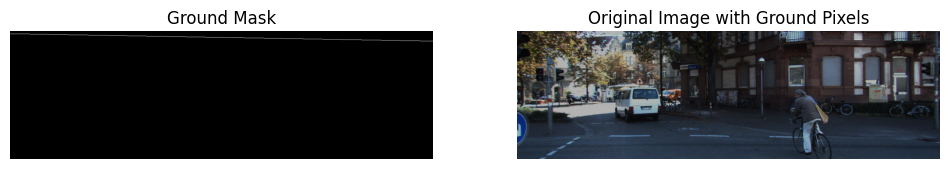

In [38]:
#TO DO: (1) display the results: the ground mask and the ground mask overlayed on the original image
#(2) compare the computed mask with the ground mask available from the dataset
#(3) answer the following questions:
#    Q1: how good are the results (ground mask)?
#    Q2: how could we improve the result? 


# Display the ground mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(groundMask, cmap='gray')
plt.title('Ground Mask')
plt.axis('off')

# Overlay ground mask on the original image
masked_image = cv2.bitwise_and(left_img, left_img, mask=groundMask)
overlay_image = cv2.addWeighted(left_img, 0.7, masked_image, 0.3, 0)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Ground Pixels')
plt.axis('off')

plt.show()

# Compare the computed mask with the ground mask available from the dataset
# You can use image differencing or other metrics to compare the masks

# Answering the questions
# Q1: Assess the quality of the ground mask results
# Q2: Propose potential improvements for better accuracy or robustness
